# Dynamic Time Warping

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.metrics import soft_dtw
from tslearn.barycenters import softdtw_barycenter
from tslearn.metrics import dtw
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

%run ../sys_configs.ipynb
%run ../plots.ipynb

np.random.seed(123)

Begin by reading in the dataset.

In [2]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]
    
with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)
    
with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)
    
classes = np.unique(y_train)  

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

## Introduction

The DTW metric considers *warping paths* through the pair of time series, which we can denote $X = (x_{1}, .., x_{p})$ and $Y = (y_{1}, ..., y_{q})$ where $x_{i} \in \mathbb{R}^{6}$, $y_{j} \in \mathbb{R}^{6}$.

In the pairwise cost matrix considered at each time step $C_{ij} = f(x_{i} , y_{j})$, we use the L2-Norm across all 6 dimensions, i.e. $f(x_{i}, y_{j}) = \sqrt{(x_{i,1}-y_{j,1})^{2} + ... + (x_{i,6}-y_{j,6})^{2}}$. 

A warping path advances exactly one step through at least one of the time series at each stage, choosing which to step forward through in such a way as to minimise the total overall warping path cost. The DTW Score is the minimum cost among all warping paths P, i.e. $DTW(X, Y) = min_{p \in P}C_{p}(X, Y)$

## Approach 1: Brute force approach

### Approach

We would anticipate that we could maximise classification performance by performing pairwise comparisons between all observations in the prediction datasets not seen by the model and those in the train dataset, then take the majority class of the nearest neighbours. This is computationally infeasible in a real-life deployment, but we examine the performance below anyway.

The rationale behind this is a single barycenter, no matter how well chosen, cannot effectively capture the heterogeneity of the train data for the class it represents.

### Prediction

In [3]:
def compute_dists(train, test):
    N_train = len(train)
    N_test = len(test)
    
    prediction_dists = np.zeros((N_test, N_train))
    
    start_time = time.time()
    for idx in tqdm(range(N_test), desc = "Computing Distances to Train Samples"):
        ts_test = test[idx, :, :]
        for idx2 in range(N_train):
            ts_train = train[idx2, :, :]
            dist = dtw(ts_test, ts_train)
            prediction_dists[idx, idx2] = dist

    print("--- %s seconds ---" % (time.time() - start_time))
    print("--- Average time per prediction: %s seconds ---" % ((time.time() - start_time)/N_test))
    return prediction_dists

In [4]:
prediction1_dists_val = compute_dists(x_train, x_val)
predictions1_dists_test = compute_dists(x_train, x_test)

Computing Distances to Train Samples: 100%|████████████████████████████████████████| 1392/1392 [30:02<00:00,  1.29s/it]


--- 1802.3393025398254 seconds ---
--- Average time per prediction: 1.2947839817096447 seconds ---


Computing Distances to Train Samples: 100%|████████████████████████████████████████| 1051/1051 [22:20<00:00,  1.28s/it]

--- 1340.71222782135 seconds ---
--- Average time per prediction: 1.275653879944196 seconds ---


In [6]:
K = 3  # Configure the number of K - Nearest Neighbours to use

# argsort along axis 1 (each row) and slice to get the first K indices
predictions1_knn_val_smallest_indices = np.argsort(prediction1_dists_val, axis=1)[:, :K]
predictions1_knn_test_smallest_indices = np.argsort(predictions1_dists_test, axis=1)[:, :K]

predictions1_val = np.array([np.bincount(row).argmax() for row in y_train[predictions1_knn_val_smallest_indices]])
predictions1_test = np.array([np.bincount(row).argmax() for row in y_train[predictions1_knn_test_smallest_indices]])

In [7]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions1_val), sum(np.equal(predictions1_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions1_test), sum(np.equal(predictions1_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 987
Test Data - Total predictions made: 1051. Number of correct predictions: 752


### Visualise predictions for test set

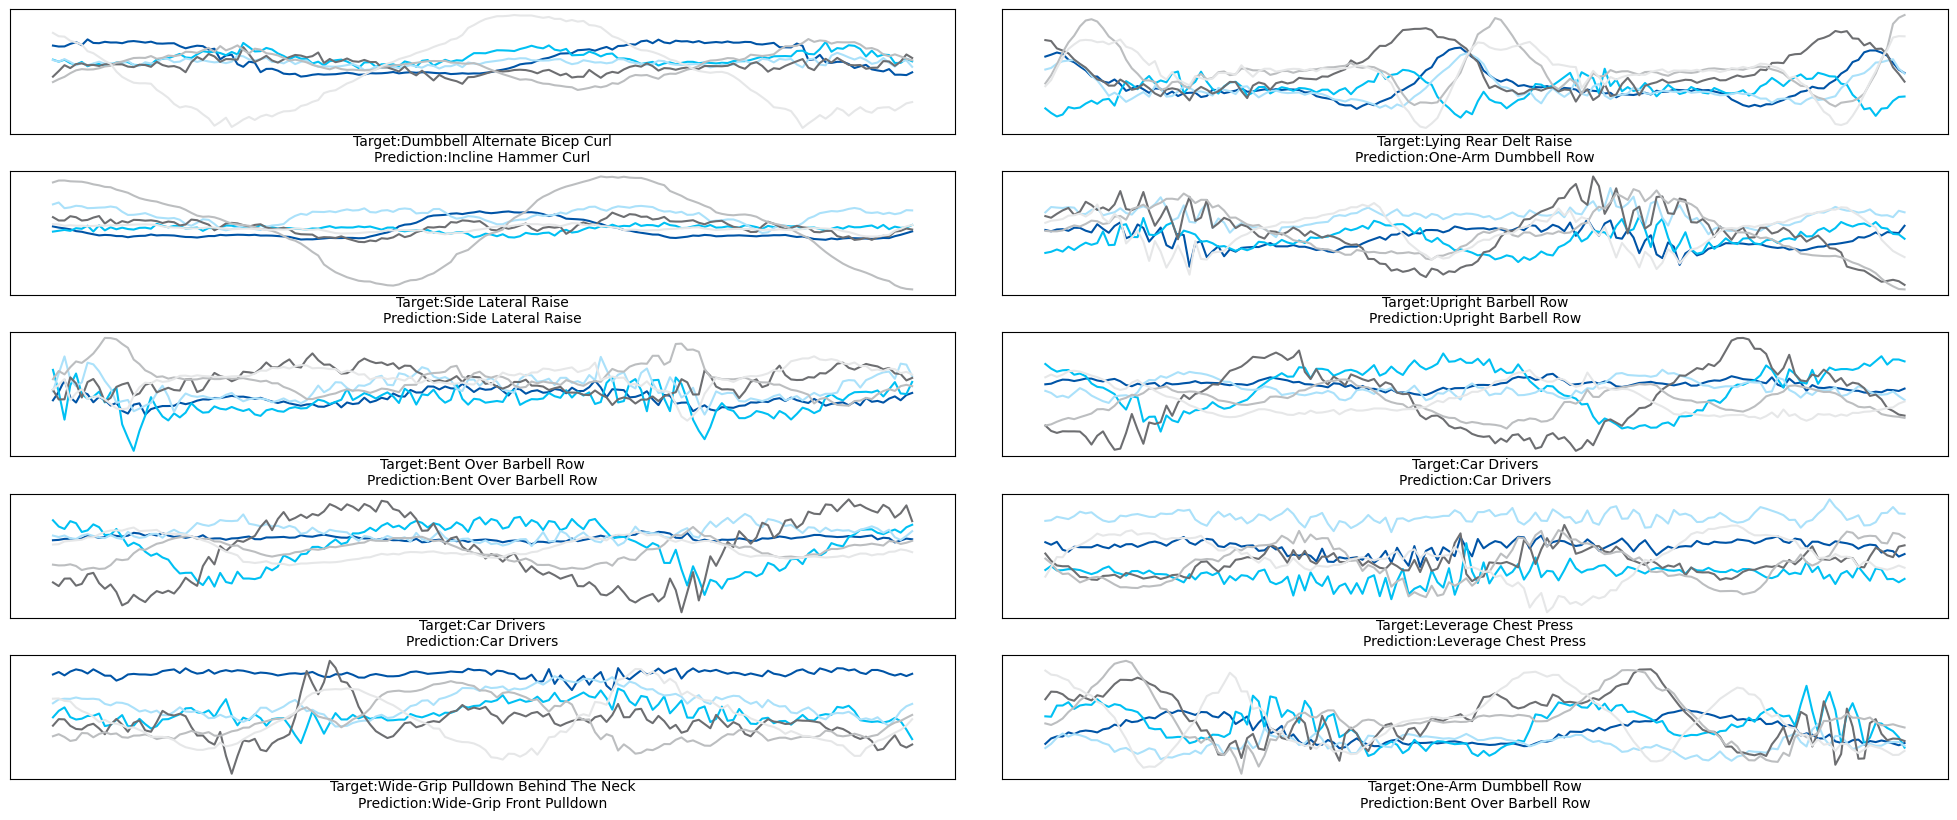

In [8]:
plot_samples(data = x_test, labels = y_test, predictions = predictions1_test)

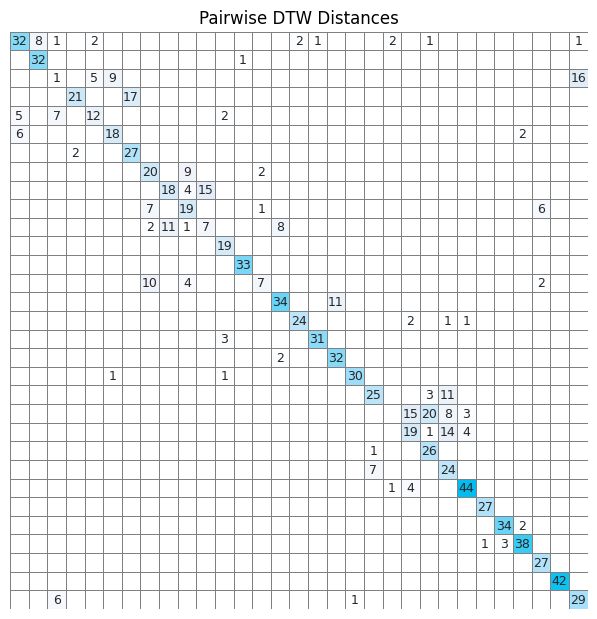

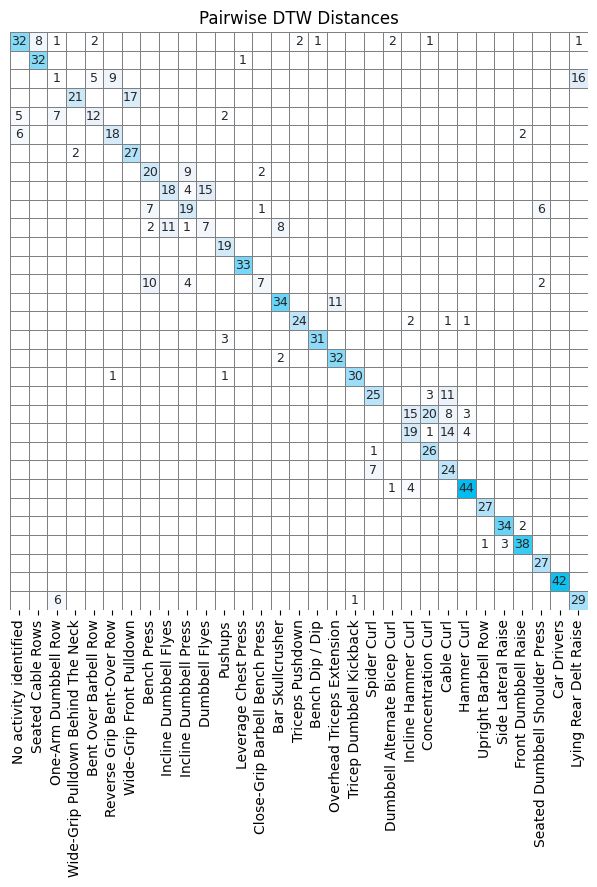

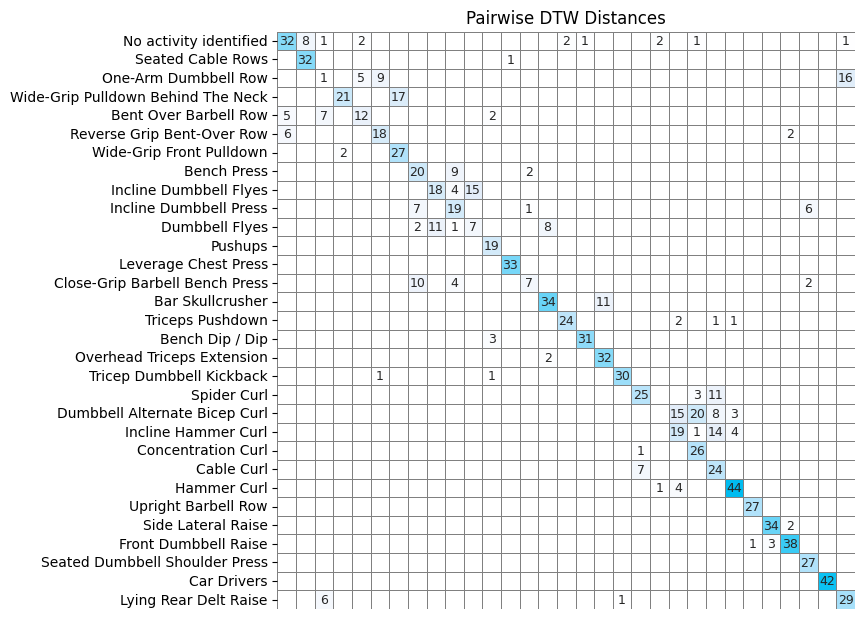

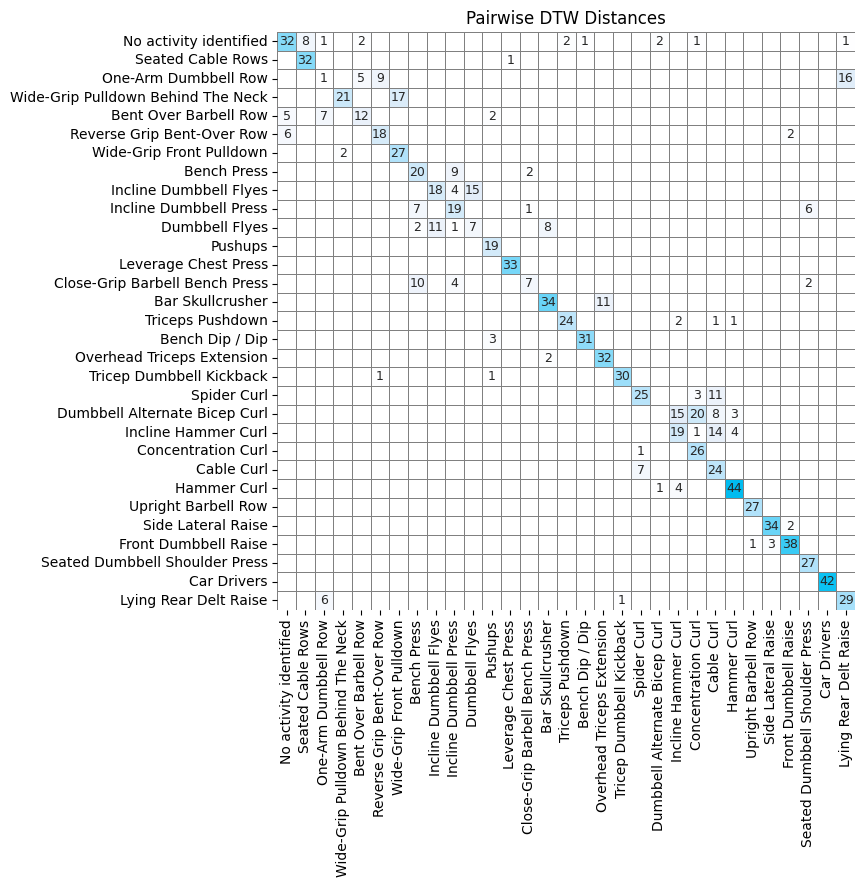

In [9]:
cm1 = confusion_matrix(y_test, predictions1_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm1, x_ticks = False, y_ticks = False, save = True, title = "Pairwise DTW Distances")
plot_confusion_matrix(cm1, x_ticks = True, y_ticks = False, save = True, title = "Pairwise DTW Distances")
plot_confusion_matrix(cm1, x_ticks = False, y_ticks = True, save = True, title = "Pairwise DTW Distances")
plot_confusion_matrix(cm1, x_ticks = True, y_ticks = True, save = True, title = "Pairwise DTW Distances")

## Approach 2: Nearest Neighbour & DTW Barycentres

### Approach

A single DTW pair comparison is $O(pq)$. The window size used in this work is 150, so DTW struggles to scale. Using DTW in a KNN classifier is also unrealistic as the train dataset has size N $\approx 10^{3}$. The prediction stage for a single prediction using KNN-DTW has order $O(Npq)$! This is infeasible for making near real-time predictions. 

Therefore, we compute DTW Barycenters using the methodology introduced in [1] for each class, and loosely consider these as central *average* time series' representative of their classes. They are chosen to minimise the sum of DTW distances to all time series in the set and are analagous to the centroid in K-means clustering, which uses the sum of squared Euclidean distances.

The advantage of using DTW Barycenters is that there is exactly 1 per class, so N = 31 classes in the $O(Npq)$ KNN prediction operation. This makes the problem ameniable to near real-time classification.

### Training

Iterate through each class and compute the barycenter. Each barycenter is of size *Time series window length x dimensionality.*

In [10]:
barycenters = np.zeros((31, sz, dim)) # Number of classes x Time series window length x Dimensionality

In [11]:
start_time = time.time()
for idx, c in tqdm(enumerate(classes), desc ="Finding Barycenters"):
    data = x_train[y_train == c, :, :]
    barycenter = dtw_barycenter_averaging(data, max_iter=5, tol=1e-5) # max_iter = 5 was found to be sufficient during testing
    barycenters[idx] = barycenter
print("--- %s seconds ---" % (time.time() - start_time))

Finding Barycenters: 31it [00:16,  1.88it/s]

--- 16.51615810394287 seconds ---


### Predictions

Compare each observation in the validation and test data with each barycenter to determine the class.

In [12]:
def compute_distances_to_barycenters(data):
    N = len(data)
    prediction_dists = np.zeros((N, 31))
    
    start_time = time.time()
    for idx in tqdm(range(N), desc = "Computing Distances to Barycenters"):
        ts = data[idx, :, :]
        for idx2 in range(31):
            center = barycenters[idx2, :, :]
            dist = dtw(ts, center)
            prediction_dists[idx, idx2] = dist
    print("--- %s seconds ---" % (time.time() - start_time))
    print("--- Average time per prediction: %s seconds ---" % ((time.time() - start_time)/N))
    
    return prediction_dists

In [13]:
val_prediction2_dists = compute_distances_to_barycenters(x_val)
test_prediction2_dists = compute_distances_to_barycenters(x_test)

Computing Distances to Barycenters: 100%|█████████████████████████████████████████| 1392/1392 [00:13<00:00, 101.42it/s]


--- 13.731019973754883 seconds ---
--- Average time per prediction: 0.009864238486892876 seconds ---


Computing Distances to Barycenters: 100%|██████████████████████████████████████████| 1051/1051 [00:10<00:00, 97.08it/s]

--- 10.830617904663086 seconds ---
--- Average time per prediction: 0.010305059852200843 seconds ---


In [14]:
# Compute the predictions and compare against the targets
predictions2_val = classes[np.argmin(val_prediction2_dists, axis = 1)]
predictions2_test = classes[np.argmin(test_prediction2_dists, axis = 1)]

print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions2_val), sum(np.equal(predictions2_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions2_test), sum(np.equal(predictions2_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 900
Test Data - Total predictions made: 1051. Number of correct predictions: 669


This method has excellent predictive ability.

### Visualise predictions for test set

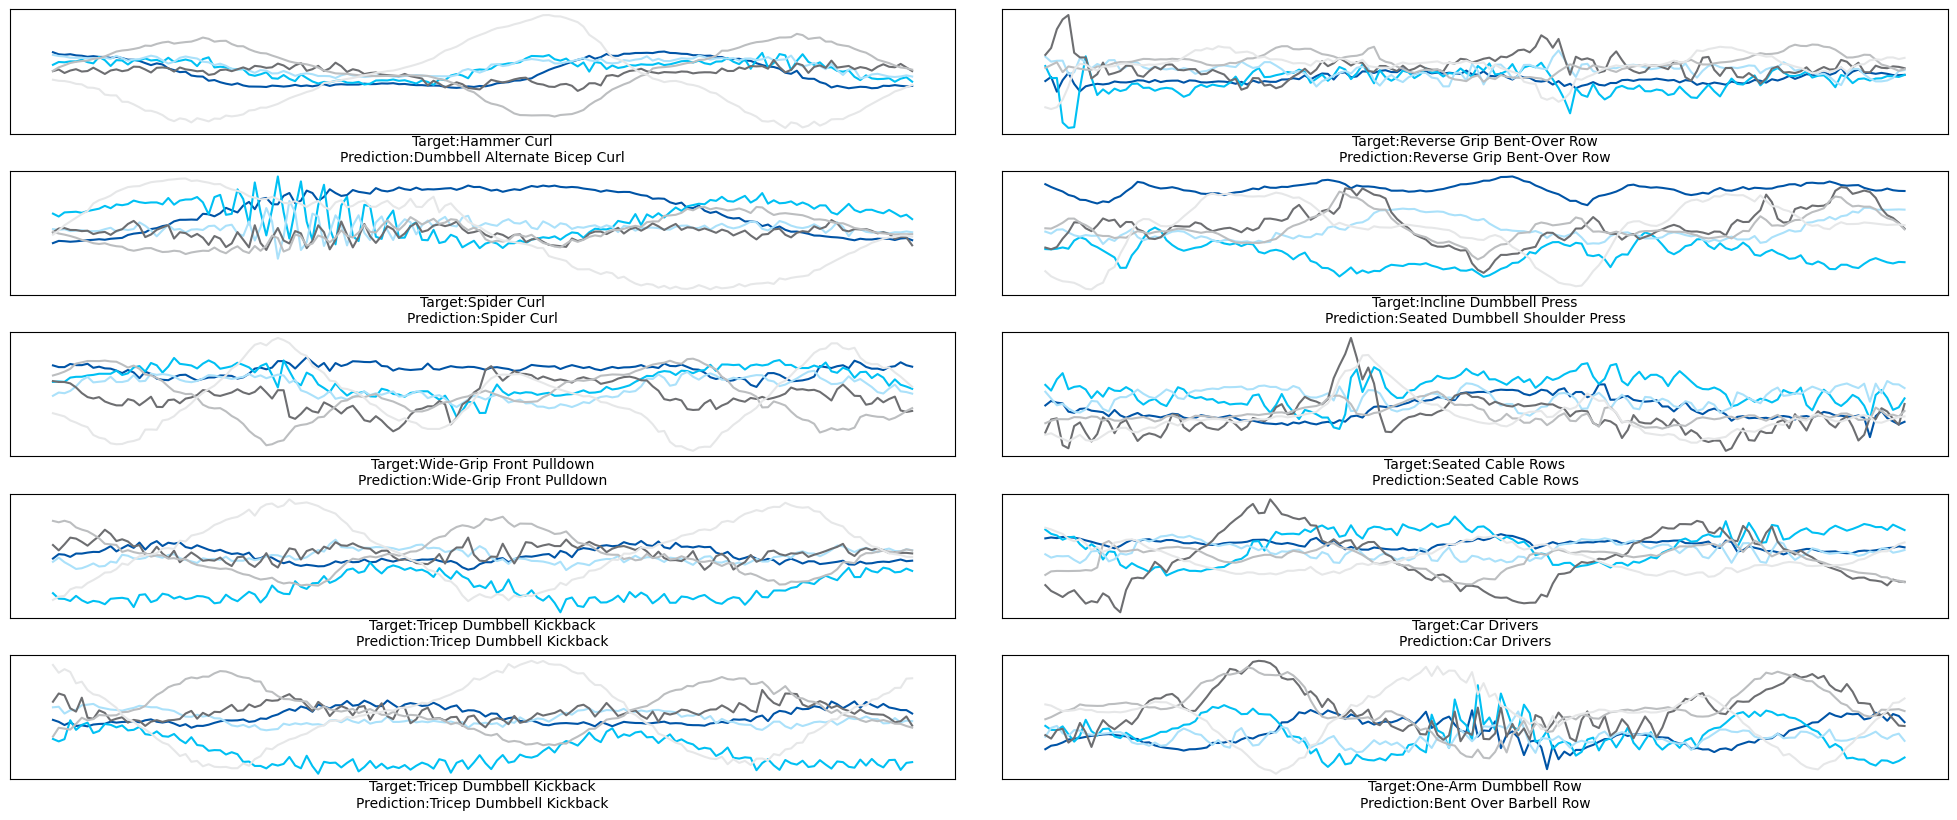

In [15]:
plot_samples(data = x_test, labels = y_test, predictions = predictions2_test)

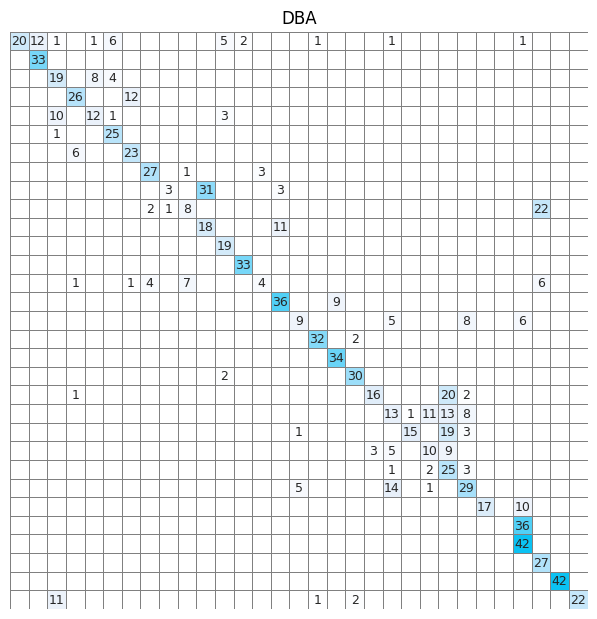

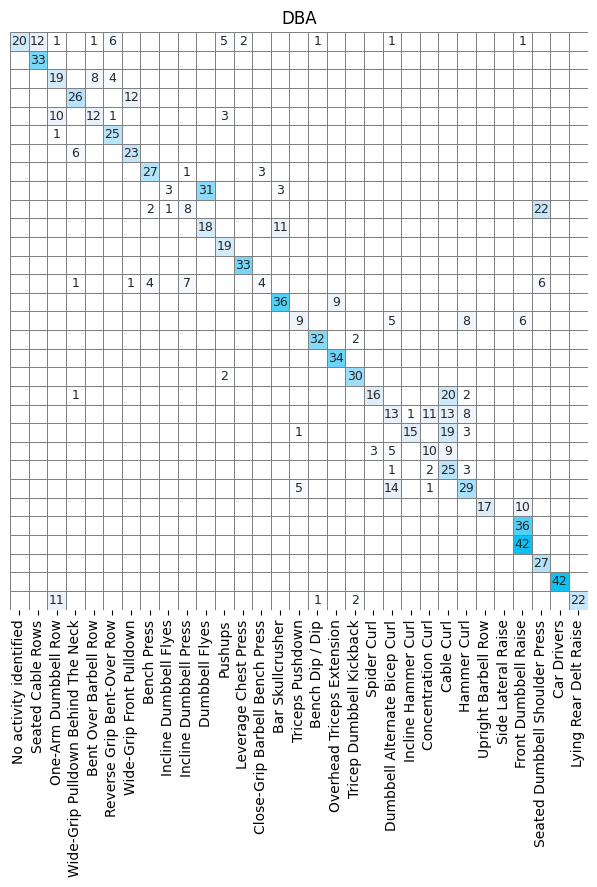

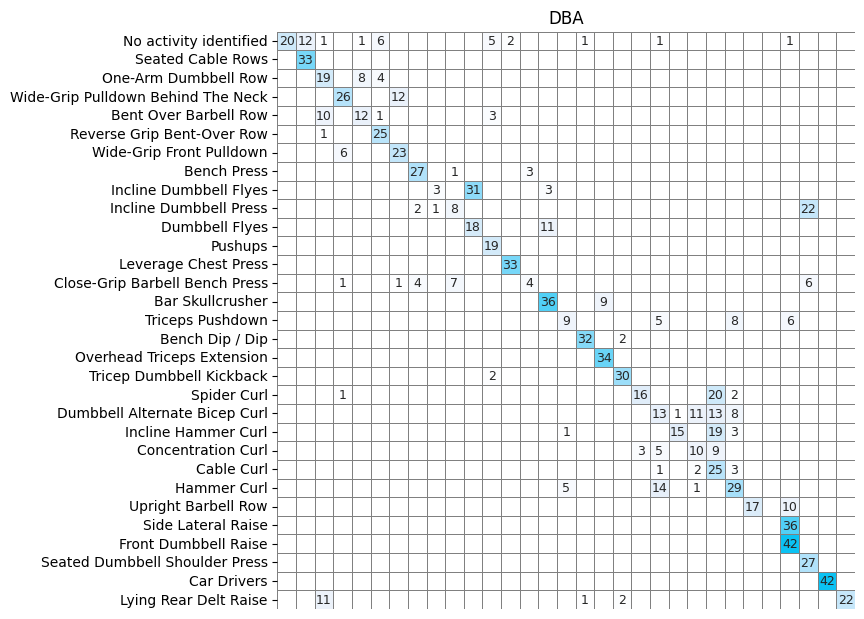

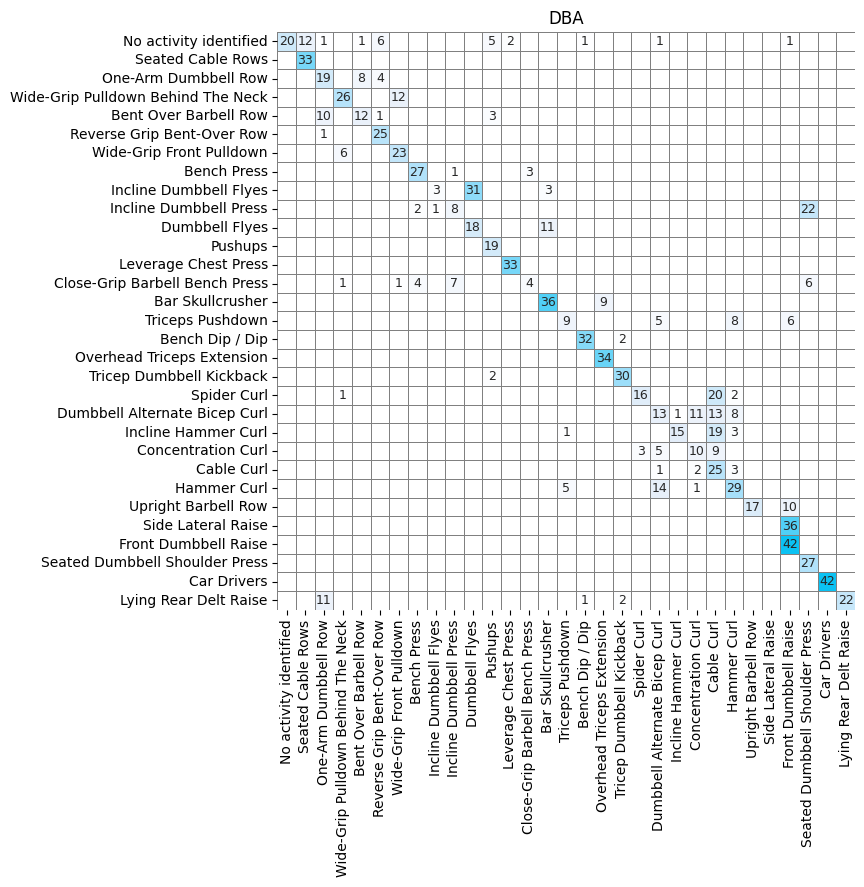

In [27]:
cm2 = confusion_matrix(y_test, predictions2_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm2, x_ticks = False, y_ticks = False, save = True, title = "DBA")
plot_confusion_matrix(cm2, x_ticks = True, y_ticks = False, save = True, title = "DBA")
plot_confusion_matrix(cm2, x_ticks = False, y_ticks = True, save = True, title = "DBA")
plot_confusion_matrix(cm2, x_ticks = True, y_ticks = True, save = True, title = "DBA")

## Approach 3: Nearest Neighbours & Soft - DTW Barycentres 

### Approach

At each pair of time indexes $(i, j)$, we defined the costs and (implicitly) the alignment path recursively as $DTW(x_{., i}, y_{., j}) = C_{i,j} + min\{DTW(x_{., i-1}, y_{., j}), DTW(x_{., i-1}, y_{., j-1}), DTW(x_{., i}, y_{., j - 1})\}$. The minimum operation applied here is not differentiable, depriving us of the ability to minimise the DTW cost with gradient descent based methods. This eludes to a major drawback of DBA, and motivates Soft-DTW Barycenter Averaging (SDBA) [2], which replaces the non-differentiable "min" operation with a differentiable "soft-min" operation (LogSumExp). Soft-min is differentiable w.r.t. its inputs for $\gamma > 0$ so is a smooth approximation to the minimum.

### Training

Iterate through each class and compute the barycenter. Each barycenter is of size *Time series window length x dimensionality.*

In [17]:
barycenters2 = np.zeros((31, sz, dim)) # Number of classes x Time series window length x Dimensionality

In [18]:
start_time = time.time()
for idx, c in tqdm(enumerate(classes), desc ="Finding Barycenters"):
    data = x_train[y_train == c, :, :]
    barycenter2 = softdtw_barycenter(data, gamma=.1)
    barycenters2[idx] = barycenter2
print("--- %s seconds ---" % (time.time() - start_time))

Finding Barycenters: 31it [06:14, 12.07s/it]

--- 374.224059343338 seconds ---


### Predictions

Compare each observation in the validation and test data with each barycenter to determine the class.

This experiment was re-run with different choices of $\gamma$, but a small $\gamma$ was found to work best.

In [21]:
def compute_softdtw_distances_to_barycenters(data):
    N = len(data)
    prediction_dists = np.zeros((N, 31))
    
    start_time = time.time()
    for idx in tqdm(range(N), desc = "Computing Distances to Barycenters"):
        ts = data[idx, :, :]
        for idx2 in range(31):
            center = barycenters2[idx2, :, :]
            dist = soft_dtw(ts, center,gamma=.1)
            prediction_dists[idx, idx2] = dist
    print("--- %s seconds ---" % (time.time() - start_time))
    print("--- Average time per prediction: %s seconds ---" % ((time.time() - start_time)/N))
    
    return prediction_dists

In [22]:
val_prediction3_dists = compute_softdtw_distances_to_barycenters(x_val)
test_prediction3_dists = compute_softdtw_distances_to_barycenters(x_test)

Computing Distances to Barycenters: 100%|██████████████████████████████████████████| 1392/1392 [01:41<00:00, 13.66it/s]


--- 101.91704225540161 seconds ---
--- Average time per prediction: 0.07321626598807587 seconds ---


Computing Distances to Barycenters: 100%|██████████████████████████████████████████| 1051/1051 [01:15<00:00, 13.87it/s]

--- 75.8056845664978 seconds ---
--- Average time per prediction: 0.07212719749428906 seconds ---


In [23]:
# Compute the predictions and compare against the targets
predictions3_val = classes[np.argmin(val_prediction3_dists, axis = 1)]
predictions3_test = classes[np.argmin(test_prediction3_dists, axis = 1)]

print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions3_val), sum(np.equal(predictions3_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions3_test), sum(np.equal(predictions3_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 925
Test Data - Total predictions made: 1051. Number of correct predictions: 695


This method has excellent predictive ability considering it uses a single barycenter per class.

### Visualise Predictions

Plot a selection of time series along with the target window activity class and the predictions from this elementary classification approach.

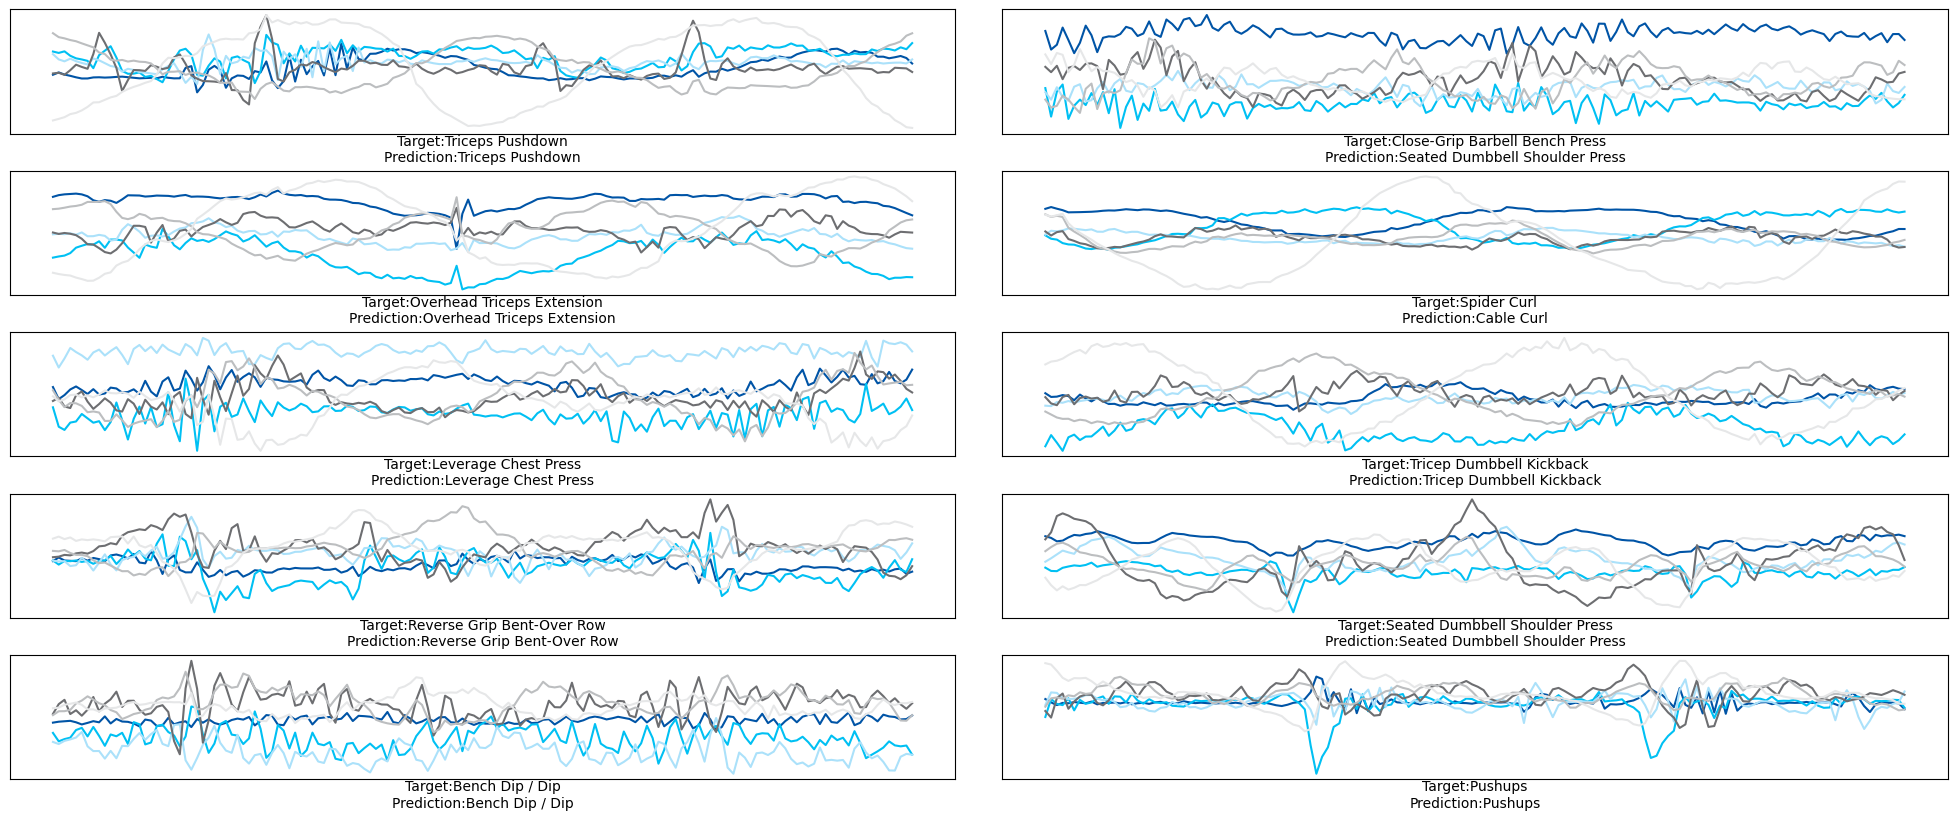

In [24]:
plot_samples(data = x_test, labels = y_test, predictions = predictions3_test)

We also plot a confusion matrix of the classifications. Observe just how poorly this method performs. The majority of missclassifications are towards the *No activity Identified* class. We could remove this class from consideration and consider the additional question of whether a time series corresponds to an activity or no activity.

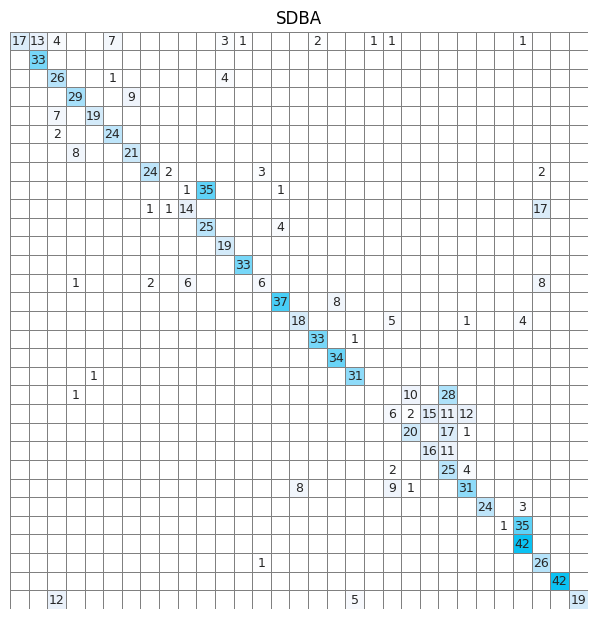

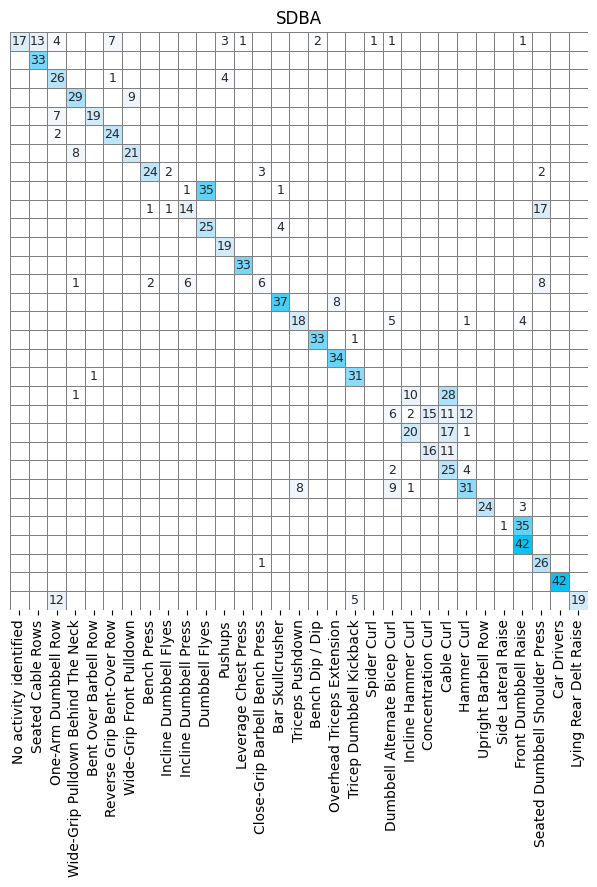

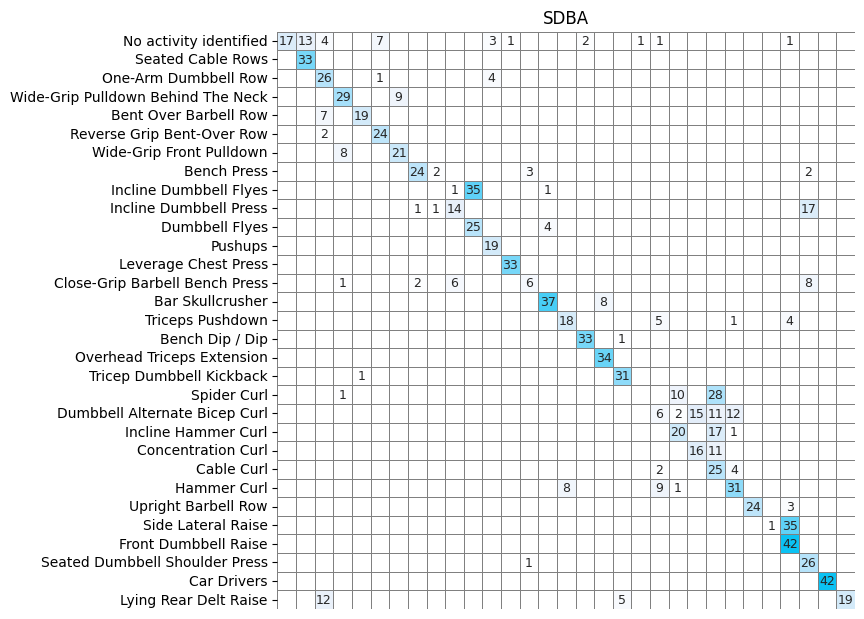

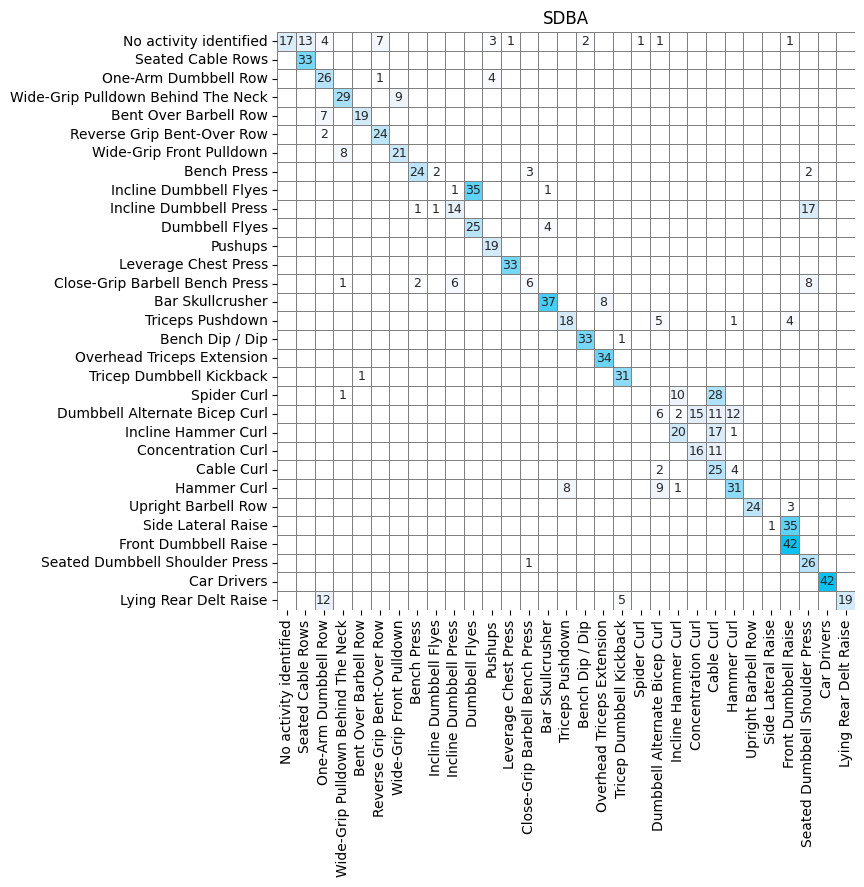

In [26]:
cm3 = confusion_matrix(y_test, predictions3_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm3, x_ticks = False, y_ticks = False, save = True, title = "SDBA")
plot_confusion_matrix(cm3, x_ticks = True, y_ticks = False, save = True, title = "SDBA")
plot_confusion_matrix(cm3, x_ticks = False, y_ticks = True, save = True, title = "SDBA")
plot_confusion_matrix(cm3, x_ticks = True, y_ticks = True, save = True, title = "SDBA")

## References

[1] Petitjean, François, Alain Ketterlin and Pierre Gançarski. “A global averaging method for dynamic time warping, with applications to clustering.” Pattern Recognit. 44 (2011): 678-693.

[2] Cuturi, Marco and Mathieu Blondel. “Soft-DTW: a Differentiable Loss Function for Time-Series.” International Conference on Machine Learning (2017).